<a href="https://colab.research.google.com/github/MihailMV/Fruits-and-vegetables/blob/master/NN_fruits_and_vegetables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
pip install MulticoreTSNE

In [6]:
pip install efficientnet_pytorch

In [1]:
import os
import shutil
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from torchvision import transforms
from torchvision.datasets import ImageFolder

from efficientnet_pytorch import EfficientNet
import torchvision
import torch

from MulticoreTSNE import MulticoreTSNE as TSNE

from sklearn.metrics import classification_report, f1_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
DIR = 'fruits_vegetables'
DIR_TRAIN = 'TRAIN'
DIR_VAL = 'VAL'
DIR_TEST = 'TEST'
IMG_SIZE = (224, 224)
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
BATCH_SIZE = 20

os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/kaggle/" 
pd.set_option('precision', 2)


In [3]:
if os.path.isdir(DIR):
  shutil.rmtree(DIR)
os.system("kaggle datasets download -p " + DIR + " --unzip balalexv/fruits-vegetables-photos")


0

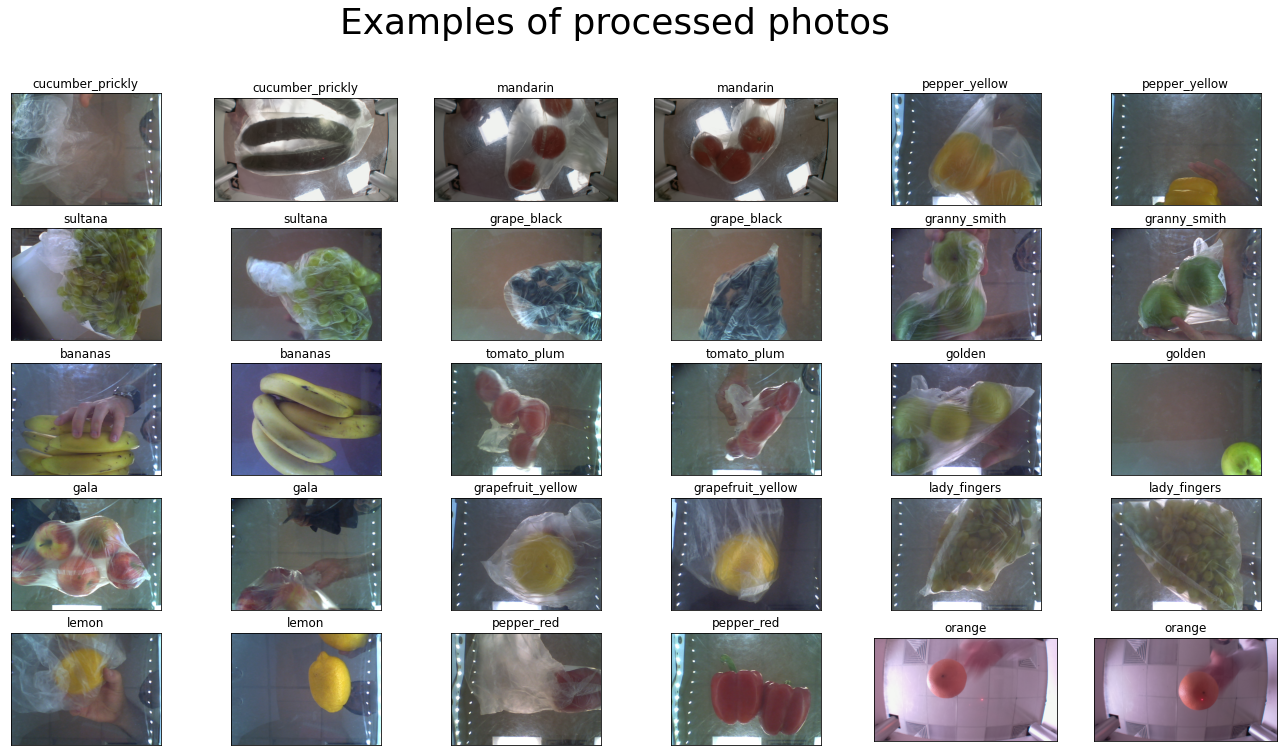

In [4]:
class_list = os.listdir(os.path.join(DIR,DIR_TRAIN))

fig=plt.figure(figsize=(23, 12))
fig.set(facecolor = 'white')
fig.suptitle('Examples of processed photos', fontsize= 36)

columns = 6
rows = 5

for i in range(columns * rows):
    fig.add_subplot(rows, columns, i + 1)
    class_name = class_list[(i)//2]
    plt.imshow(Image.open(os.path.join(DIR,DIR_TRAIN,class_name,os.listdir(os.path.join(DIR,DIR_TRAIN, class_name))[np.random.randint(len(os.listdir(os.path.join(DIR,DIR_TRAIN, class_name))))])))
    plt.title(class_name)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

In [0]:
os.makedirs(os.path.join(DIR, DIR_VAL), exist_ok=True)

class_list = os.listdir(os.path.join(DIR,DIR_TRAIN))
cnt_train_list = []
cnt_val_list = []
cnt_test_list = []

for class_name in class_list:
  os.makedirs(os.path.join(DIR, DIR_VAL, class_name), exist_ok=True)
  for f in os.listdir(os.path.join(DIR,DIR_TRAIN, class_name)):
    if (np.random.randint(1, 11) == 1):
      shutil.move(os.path.join(DIR,DIR_TRAIN, class_name,f), os.path.join(DIR,DIR_VAL,class_name,f))
  cnt_train_list.append(len(os.listdir(os.path.join(DIR,DIR_TRAIN, class_name))))
  cnt_val_list.append(len(os.listdir(os.path.join(DIR,DIR_VAL, class_name))))
  cnt_test_list.append(len(os.listdir(os.path.join(DIR,DIR_TEST, class_name))))
  
df = pd.DataFrame({'CLASS':class_list, 'CNT_TRAIN':cnt_train_list, 'CNT_VAL':cnt_val_list, 'CNT_TEST':cnt_test_list})
df['CNT_ALL'] = df.sum(axis=1)
del class_list, cnt_train_list, cnt_val_list, cnt_test_list

In [6]:
df

,CLASS,CNT_TRAIN,CNT_VAL,CNT_TEST,CNT_ALL
0,cucumber_prickly,608,80,9,697
1,mandarin,120,8,9,137
2,pepper_yellow,158,16,9,183
3,sultana,497,52,9,558
4,grape_black,192,26,9,227
5,granny_smith,386,53,9,448
6,bananas,643,64,9,716
7,tomato_plum,502,53,9,564
8,golden,262,23,9,294
9,gala,531,60,9,600


In [7]:
df.describe()

,CNT_TRAIN,CNT_VAL,CNT_TEST,CNT_ALL
count,15.00,15.00,15.0,15.00
mean,338.87,38.33,9.0,386.20
std,218.15,25.30,0.0,242.89
min,54.00,8.00,9.0,71.00
25%,157.50,18.50,9.0,185.50
50%,262.00,26.00,9.0,294.00
75%,516.50,56.50,9.0,582.00
max,676.00,80.00,9.0,762.00


In [0]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(0.5,0.5,0.5),
    transforms.RandomRotation(degrees=90),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

val_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

train_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_TRAIN), train_transforms)
val_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_VAL), val_transforms)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)


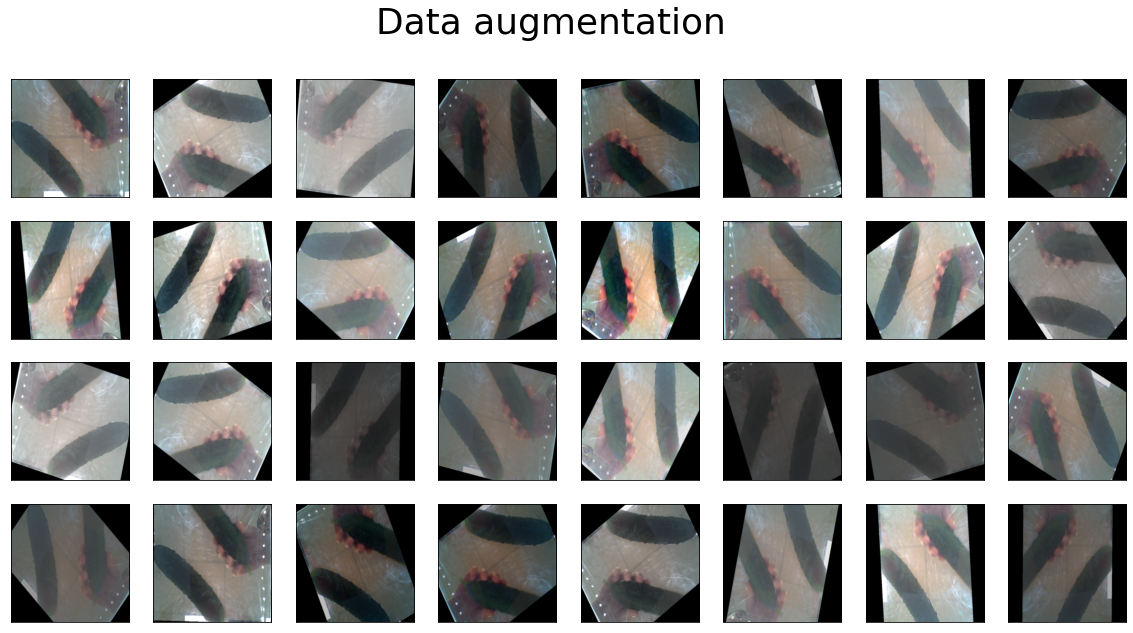

In [9]:
fig=plt.figure(figsize=(20, 10))
fig.set(facecolor = 'white')
fig.suptitle('Data augmentation', fontsize= 36)

columns = 8
rows = 4
class_name = df['CLASS'][np.random.randint(df.shape[0])]
num_photo = np.random.randint(len(os.listdir(os.path.join(DIR,DIR_TRAIN, class_name))))
img = Image.open(os.path.join(DIR,DIR_TRAIN,class_name,os.listdir(os.path.join(DIR,DIR_TRAIN, class_name))[num_photo]))

for i in range(columns * rows):
    fig.add_subplot(rows, columns, i + 1)
    if (i == 0):
      plt.imshow((val_transforms(img).permute(1, 2, 0).numpy() * STD + MEAN).clip(0, 1))
    else:
      plt.imshow((train_transforms(img).permute(1, 2, 0).numpy() * STD + MEAN).clip(0, 1))
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

In [0]:
def train_model(model, fun_loss, optimizer, scheduler, cnt_epochs, hist = None):
  if (hist == None):
    hist = {'Epochs': [], 'Train loss': [],'Train F1': [],'Val loss': [],'Val F1': []}
    start_epoch = 1
  else:
    start_epoch = hist['Epochs'][-1]+1
  type_trains = ['Train','Val']
  for epoch in range(start_epoch, start_epoch+cnt_epochs):
    for id_type_train in range(2):
      loss = 0.
      preds_class_all = torch.tensor([], dtype=int)
      labels_all = torch.tensor([], dtype=int)
      if (id_type_train == 0):
        model.train()
        dataloader = train_dataloader
      else:
        model.eval()
        dataloader = val_dataloader
      for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(id_type_train == 0):
          preds = model(inputs)
          loss_batch = fun_loss(preds, labels)
          preds_class = preds.argmax(dim=1)
          if (id_type_train == 0):
            loss_batch.backward()
            optimizer.step()
          loss += loss_batch.item()
          preds_class_all = torch.cat([preds_class_all, preds_class.cpu()])
          labels_all = torch.cat([labels_all, labels.data.cpu()])
      
      loss /= len(dataloader)
      if (id_type_train == 0):
        scheduler.step(loss)
        hist['Epochs'].append(epoch)  
      hist[f'{type_trains[id_type_train]} loss'].append(loss)
      hist[f'{type_trains[id_type_train]} F1'].append(f1_score(labels_all, preds_class_all, average='macro'))
        
    print(f"Epoch {epoch}/{start_epoch+cnt_epochs-1}: Train: Loss: {hist['Train loss'][-1]:.4f}, F1 score: {hist['Train F1'][-1]:.4f}   Val: Loss: {hist['Val loss'][-1]:.4f}, F1 score: {hist['Val F1'][-1]:.4f}")
  return model, hist

In [11]:
model = EfficientNet.from_pretrained("efficientnet-b4", num_classes = len(train_dataset.classes))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

cl_cnt = dict(df[['CLASS','CNT_TRAIN']].values)
cl_weight = max([cnt for cnt in cl_cnt.values()]) / torch.tensor([cl_cnt[cl] for cl in train_dataset.classes], dtype=float, device=device)

loss = torch.nn.CrossEntropyLoss(weight=cl_weight.float())
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4,  amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.3, patience=3, threshold= 0.01, verbose=True)

Loaded pretrained weights for efficientnet-b4


In [12]:
model, hist = train_model(model, loss, optimizer, scheduler, cnt_epochs=1)

Epoch 1/1: Train: Loss: 1.1762, F1 score: 0.6766   Val: Loss: 0.1405, F1 score: 0.9606


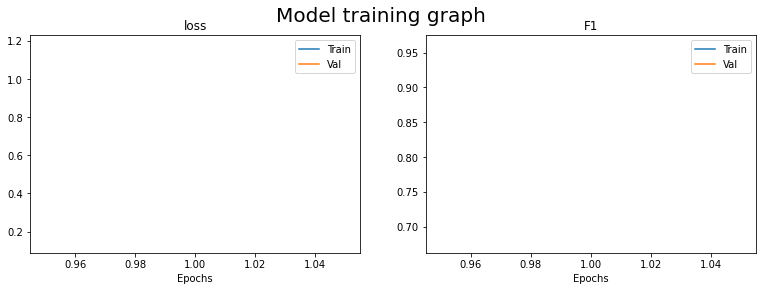

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
fig.set(facecolor = 'white')
fig.suptitle('Model training graph', fontsize= 20)

funs = ['loss','F1']
type_trains = ['Train','Val']

for fun in funs:
  for type_train in type_trains:
    axes[funs.index(fun)].plot(hist['Epochs'], hist[f'{type_train} {fun}'], label=type_train)
  axes[funs.index(fun)].set_title(fun)
  axes[funs.index(fun)].set_xlabel('Epochs')
  axes[funs.index(fun)].legend()
plt.show()

In [14]:
test_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_TEST), val_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

model.eval()
preds_class_all = []
labels_all =  []
preds_all = np.array([])

for inputs, labels in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
        preds_class = preds.argmax(dim=1)
        preds_class_all = preds_class_all + preds_class.cpu().tolist()
        labels_all = labels_all + labels.data.cpu().tolist()
        if (preds_all.shape[0] == 0):
          preds_all = np.array(preds.cpu().data)
        else:
          preds_all = np.concatenate([preds_all, np.array(preds.cpu().data)])

del inputs, labels
print(classification_report(labels_all, preds_class_all, target_names = train_dataset.classes))

                   precision    recall  f1-score   support

          bananas       1.00      1.00      1.00         9
 cucumber_prickly       1.00      1.00      1.00         9
             gala       1.00      1.00      1.00         9
           golden       0.88      0.78      0.82         9
     granny_smith       1.00      0.89      0.94         9
      grape_black       1.00      1.00      1.00         9
grapefruit_yellow       0.90      1.00      0.95         9
     lady_fingers       1.00      0.67      0.80         9
            lemon       0.80      0.89      0.84         9
         mandarin       1.00      1.00      1.00         9
           orange       1.00      1.00      1.00         9
       pepper_red       0.90      1.00      0.95         9
    pepper_yellow       1.00      1.00      1.00         9
          sultana       0.75      1.00      0.86         9
      tomato_plum       1.00      0.89      0.94         9

         accuracy                           0.94      

In [0]:
tsne = TSNE(n_jobs=-1,random_state=42)

photos = []
labels_all = []

for class_name in os.listdir(os.path.join(DIR,DIR_TEST)):
  for file_name in os.listdir(os.path.join(DIR,DIR_TEST, class_name)):
    photos.append(np.array(val_transforms(Image.open(os.path.join(DIR,DIR_TEST,class_name,file_name))).view(-1)))
    labels_all.append(class_name)

photos = np.array(photos)

tsne_rep_photos = tsne.fit_transform(photos)
tsne_rep_preds = tsne.fit_transform(preds_all)



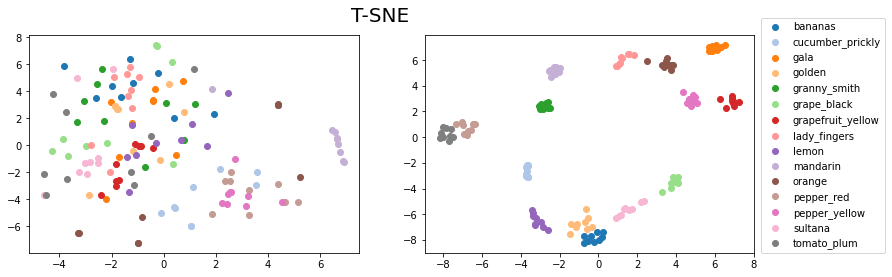

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
fig.set(facecolor = 'white')
fig.suptitle('T-SNE', fontsize= 20)
colors = plt.cm.get_cmap('tab20')

for i, class_name in enumerate(train_dataset.classes):
  class_filter = [class_name == label for label in labels_all]
  axes[0].scatter(x=tsne_rep_photos[class_filter, 0], y=tsne_rep_photos[class_filter, 1], color=colors.colors[i], label=class_name)
  axes[1].scatter(x=tsne_rep_preds[class_filter, 0], y=tsne_rep_preds[class_filter, 1], color=colors.colors[i], label=class_name)
axes[1].legend(loc = (1.02, 0))
plt.show()

In [0]:
def Occlusion(model, img, class_id, batch_size = 32, size_square = 20, size_step = 5):
  img = img.view([1] + list(img.size()))
  len_row = img.size()[2] // size_step + 1
  len_col = img.size()[3] // size_step + 1
  confidence_predict = []
  i = 0
  j = 0

  for num_batcn in range(1, (len_row * len_col) // batch_size + 2):
    cnt_img = batch_size - max(0,num_batcn * batch_size - (len_row * len_col))
    #print(num_batcn, cnt_img) #406
    imgs = torch.cat([img for i in range(cnt_img)])  
    for num_img in range(cnt_img):
      imgs[num_img, :, i*size_step:i*size_step+size_square, j*size_step:j*size_step+size_square] *= 0
      j += 1
      if (j == len_col):
        i += 1
        j = 0 
    confidence_predict = np.concatenate([confidence_predict ,list(torch.nn.functional.softmax(model(imgs).data ,dim=1)[:,class_id].cpu().numpy())])


  new_img = torch.zeros(img.size()[2:])
  new_img_cnt = torch.zeros(img.size()[2:])

  #print(confidence_predict.min(), confidence_predict.max())
  for i in range(len_row):
    for j in range(len_col):
      new_img[i*size_step:i*size_step+size_square, j*size_step:j*size_step+size_square] += confidence_predict[i* len_row + j]
      new_img_cnt[i*size_step:i*size_step+size_square, j*size_step:j*size_step+size_square] += 1

  new_img /= new_img_cnt
  #show_input(img[0].cpu())
  #new_img = (new_img - new_img.min()) / (new_img.max() - new_img.min())
  #show_input(torch.cat([1-new_img.view([1] + list(img.size()[2:])), torch.zeros([1] + list(img.size()[2:])), new_img.view([1] + list(img.size()[2:]))]), normalize=False)
  #img_Saliency
  img2 = img.clone()
  img2.requires_grad = True

  img = img[0].cpu().permute(1, 2, 0).numpy()
  img = STD * img + MEAN
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
  fig.set(facecolor = 'white')
  axes[0].imshow(img.clip(0, 1))
  axes[0].set(title = 'Original', xticks=[], yticks=[])


  im = axes[2].imshow(new_img, cmap='RdBu')
  axes[2].set(title = 'Occlusion', xticks=[], yticks=[])
  fig.colorbar(im, ax=axes.ravel().tolist())
  
  
  optimizer = torch.optim.Adam([img2], lr=1.0e-1, weight_decay = 0.05, amsgrad=True)
  optimizer.zero_grad()
  loss_value = loss(model(img2), torch.tensor([class_id]).to(device))
  loss_value.backward()
  optimizer.step()
  new_img = -img2.grad.abs().sum(dim=(0,1)).cpu()
  new_img = new_img - new_img.median() / 2
  new_img = new_img.data.relu()
  im2 = axes[1].imshow(new_img)
  axes[1].set(title = 'Saliency', xticks=[], yticks=[])
 
  plt.show()



    #plt.imshow(image.clip(0, 1))
    #plt.title(title)
    
    #plt.pause(0.001)


In [0]:
num_photo = 99
img = train_dataloader.dataset[num_photo][0].to(device)
class_id = train_dataloader.dataset[num_photo][1]
#Occlusion(model, img, class_id, batch_size = 5, size_square = 20, size_step = 5)


In [45]:
Occlusion(model, img, class_id, batch_size = 5, size_square = 20, size_step = 5)


IndexError: ignored

In [18]:
!nvidia-smi

Mon Apr 27 01:22:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    27W /  75W |   5797MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  